In [ ]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Loading the Data

In [2]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("df_all.csv", index_col="startTime", parse_dates=True)

# Crop the DataFrame from 2021-07-01 to 2025-06-30
df = df.loc["2021-07-01":"2025-06-30"]

# Drop unnecessary columns
df = df.drop(columns=[
    'Forecast Wind',
    'Forecast Solar',
    'Actual Wind',
    'Actual Solar',
    'Settlement Period',
])

# Calculate time of day features
minutes = df.index.hour * 60 + df.index.minute
frac_day = minutes / (24 * 60)
df['tod_sin'] = np.sin(2 * np.pi * frac_day)
df['tod_cos'] = np.cos(2 * np.pi * frac_day)

# Calculate day of week features
day_of_week = df.index.dayofweek
frac_week = day_of_week / 7
df['dow_sin'] = np.sin(2 * np.pi * frac_week)
df['dow_cos'] = np.cos(2 * np.pi * frac_week)

# Calculate month of year features
month = df.index.month
frac_year = (month - 1) / 12
df['moy_sin'] = np.sin(2 * np.pi * frac_year)
df['moy_cos'] = np.cos(2 * np.pi * frac_year)

display(df.head())

Imbalance Price  Imbalance Volume  Market Price  \
startTime                                                              
2021-07-01 00:00:00        113.94985          308.0143        103.56   
2021-07-01 00:30:00        115.00000          285.1520        106.18   
2021-07-01 01:00:00        114.00000          206.0085        106.23   
2021-07-01 01:30:00        115.00000          106.1017        105.74   
2021-07-01 02:00:00        115.00000          147.7134        106.00   

                     Market Volume  Wind Error  Solar Error  Demand Error  \
startTime                                                                   
2021-07-01 00:00:00         618.45    -110.976          0.0         113.0   
2021-07-01 00:30:00         649.10    -107.774          2.0         512.0   
2021-07-01 01:00:00         555.80    -147.463          0.0         742.0   
2021-07-01 01:30:00         501.70     -89.914          0.0        1066.0   
2021-07-01 02:00:00         687.65      -2.433          0.0        1163.0   

                     De-Rated Margin (1h)  Inter Delta  Non-BM   tod_sin  \
startTime                                                                  
2021-07-01 00:00:00             12122.264         12.0     0.0  0.000000   
2021-07-01 00:30:00             12445.298        -22.0     0.0  0.130526   
2021-07-01 01:00:00             12796.294         48.0     0.0  0.258819   
2021-07-01 01:30:00             12971.661       -168.0     0.0  0.382683   
2021-07-01 02:00:00             13257.469         62.0     0.0  0.500000   

                      tod_cos   dow_sin   dow_cos       moy_sin  moy_cos  
startTime                                                                 
2021-07-01 00:00:00  1.000000  0.433884 -0.900969  1.224647e-16     -1.0  
2021-07-01 00:30:00  0.991445  0.433884 -0.900969  1.224647e-16     -1.0  
2021-07-01 01:00:00  0.965926  0.433884 -0.900969  1.224647e-16     -1.0  
2021-07-01 01:30:00  0.923880  0.433884 -0.900969  1.224647e-16     -1.0  
2021-07-01 02:00:00  0.866025  0.433884 -0.900969  1.224647e-16     -1.0

# Hyperparameter Setup

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# ─── 1) Train/Val/Test Split ────────────────────────────────────────

train_end = '2025-03-01'  # start of validation
val_end   = '2025-05-01'  # start of test

# slice once …
train_df = df.loc[:train_end]
val_df   = df.loc[train_end:val_end]
test_df  = df.loc[val_end:]

# … then unpack X & y in one go without repeating .drop
X_train, y_train = train_df.drop(columns=['Imbalance Price']), train_df['Imbalance Price']
X_val,      y_val      = val_df.drop(columns=['Imbalance Price']),    val_df['Imbalance Price']
X_test,     y_test     = test_df.drop(columns=['Imbalance Price']),   test_df['Imbalance Price']


# ─── 2) Class Definitions ───────────────────────────────────────────

# ──────────── a. Dataset Definition ─────────────────────────────────

class LSTMDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return self.X.shape[0] - self.seq_len + 1

    def __getitem__(self, idx):
        x_seq    = self.X[idx : idx + self.seq_len]
        y_target = self.y[idx + self.seq_len - 1]
        return x_seq, y_target


# ──────────── b. Layer Definitions ──────────────────────────────────

class SeasonalAttn(nn.Module):
    def __init__(self, seq_len=48):
        super().__init__()
        self.attn = nn.Parameter(torch.empty(seq_len))
        nn.init.uniform_(self.attn, -0.01, 0.01)

    def forward(self, x):
        return x * self.attn.view(1, -1, 1) # (B,N,F)


class BiLSTM(nn.Module):
    def __init__(self, num_feats, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_feats,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )

    def forward(self, x):
        out, (_ , _) = self.lstm(x)
        return out


class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        e = self.v(torch.tanh(self.W_h(x)))   # (B, N, 1)
        alpha = torch.softmax(e, dim=1)       # (B, N, 1)
        context = torch.sum(alpha * x, dim=1) # (B, 2H)
        return context


# ──────────── c. Model Definitions ──────────────────────────────────

class SA_BiLSTM(nn.Module):
    def __init__(self, num_feats, seq_len=48, hidden_size=64, num_layers=2):
        super().__init__()
        self.seasonal = SeasonalAttn(seq_len)
        self.lstm = BiLSTM(num_feats, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.seasonal(x)       # (B, N, F)
        out = self.lstm(x)         # (B, N, 2H)
        last = out[:, -1, :]       # (B, 2H)
        return self.fc(last).squeeze(-1)  # (B,)


class SA_BiLSTM_AttnPool(nn.Module):
    def __init__(self, num_feats, seq_len=48, hidden_size=64, num_layers=2):
        super().__init__()
        self.seasonal = SeasonalAttn(seq_len)
        self.lstm = BiLSTM(num_feats, hidden_size, num_layers)
        self.pool = AttentionPool(input_dim=hidden_size * 2, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.seasonal(x)       # (B, N, F)
        out = self.lstm(x)         # (B, N, 2H)
        context = self.pool(out)   # (B, 2H)
        return self.fc(context).squeeze(-1)  # (B,)

MODEL_FACTORY = {
    "SA_BiLSTM": SA_BiLSTM,
    "SA_BiLSTM_AttnPool": SA_BiLSTM_AttnPool
}

LOSS_FACTORY = {
    "MAE": nn.L1Loss,
    "MSE": nn.MSELoss,
    "Huber": nn.SmoothL1Loss
}

# ─── 3) Device ───────────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


# ─── 4) Time‐feature lists and scaler ────────────────────────────────

time_feats  = ['tod_sin','tod_cos','dow_sin','dow_cos','moy_sin','moy_cos']
other_feats = [c for c in X_train.columns if c not in time_feats]

TRANSFORMER_FACTORY = {
    "MinMax": MinMaxScaler,
    "Robust": RobustScaler,
    "Standard": StandardScaler
}


# ─── 5) CV Splitter & Hyperparameters ───────────────────────────────

tscv        = TimeSeriesSplit(n_splits=6, gap=0)
seq_len     = 48
batch_size  = 128
lr          = 1e-5
hidden_size = 64
num_layers  = 2
max_epochs  = 100
patience    = 10
scaler_used = "Robust"
model_used  = "SA_BiLSTM"
loss_used   = "Huber"
beta        = 0.1 # For Huber loss only

if loss_used == "Huber":
    beta_str = str(beta).replace(".", "p")
    loss_name = f"Huber{beta_str}"
else:
    loss_name = loss_used


# ─── 6) Model Tag & Directory ────────────────────────────────────────         

md = {
    "model":         model_used,
    "scaler":        scaler_used,
    "loss":          loss_used,
    **({"beta": beta} if loss_used == "Huber" else {}),
    "learning_rate": lr,
    "batch_size":    batch_size,
    "hidden_size":   hidden_size,
    "num_layers":    num_layers,
    "seq_len":       seq_len,
    "max_epochs":    max_epochs,
    "patience":      patience,
}

initials = lambda s: "".join(w[0] for w in s.split("_"))

parts = []
for k, v in md.items():
    parts.append(str(v) if k in ("model","scaler","loss") else f"{initials(k)}{v}")
tag = "_".join(parts)
final_tag = tag.replace(".","p")

base_dir = os.path.join("models", final_tag)
os.makedirs(base_dir, exist_ok=True)

Using device: mps


# Cross-Validation

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import json
import copy
import numpy as np
import torch
import os

cv_logs = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trainval), 1):
    # ─── Split & scale ───────────────────────────────────────────
    X_tr_df, X_val_df = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr_s,  y_val_s  = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    transformer = ColumnTransformer(
        [('scale', MinMaxScaler(), other_feats)],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    X_tr_np  = transformer.fit_transform(X_tr_df)
    X_val_np = transformer.transform(X_val_df)

    scaler_y = MinMaxScaler().fit(y_tr_s.values.reshape(-1,1))
    y_tr_np  = scaler_y.transform(y_tr_s.values.reshape(-1,1)).flatten()
    y_val_np = scaler_y.transform(y_val_s.values.reshape(-1,1)).flatten()

    # ─── DataLoaders ──────────────────────────────────────────────
    train_ds     = LSTMDataset(X_tr_np, y_tr_np, seq_len)
    val_ds       = LSTMDataset(X_val_np, y_val_np, seq_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, pin_memory=True)

    # ─── Model & optimizer ────────────────────────────────────────
    model     = MODEL_FACTORY[model_used](
                    num_feats=X_tr_np.shape[1],
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    seq_len=seq_len
                ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()

    # ─── Train with early stopping ─────────────────────────────────
    best_val_loss, epochs_no_imp = float('inf'), 0
    best_state = None

    for epoch in range(1, max_epochs+1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(-1), yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb).squeeze(-1), yb).item()
        val_loss /= len(val_loader)

        print(f"Fold {fold}, Epoch {epoch}/{max_epochs}, "
              f"Train MAE={train_loss:.4f}, Val MAE={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss, epochs_no_imp = val_loss, 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f"Early stopping at fold {fold}, epoch {epoch}")
                break

    # ─── Inference on this fold’s val ─────────────────────────────
    model.load_state_dict(best_state)
    model.eval()
    scaled_preds, scaled_trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            p  = model(xb).squeeze(-1).cpu().numpy()
            scaled_preds.append(p)
            scaled_trues.append(yb.numpy())
    scaled_preds = np.concatenate(scaled_preds)
    scaled_trues = np.concatenate(scaled_trues)

    preds_gbp = scaler_y.inverse_transform(scaled_preds.reshape(-1,1)).flatten()
    trues_gbp = scaler_y.inverse_transform(scaled_trues.reshape(-1,1)).flatten()

    mae  = mean_absolute_error(trues_gbp, preds_gbp)
    rmse = np.sqrt(mean_squared_error(trues_gbp, preds_gbp))
    smape = np.mean(2.0 * np.abs(trues_gbp - preds_gbp) /
                    (np.abs(trues_gbp) + np.abs(preds_gbp) + 1e-8)) * 100

    cv_logs.append({
        'fold':     fold,
        'mae':      mae,
        'rmse':     rmse,
        'smape':    smape
    })

    # ─── Save fold checkpoint ──────────────────────────────────────
    ckpt = {
        'model_state_dict':     best_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'transformer':          transformer,
        'scaler_y':             scaler_y,
        'hyperparams': {
            'lr':          lr,
            'batch_size':  batch_size,
            'hidden_size': hidden_size,
            'num_layers':  num_layers,
            'seq_len':     seq_len
        },
        'fold_metrics': {
            'mae':   mae,
            'rmse':  rmse,
            'smape': smape
        }
    }
    torch.save(ckpt, os.path.join(base_dir, f"checkpoint_fold{fold}.pt"))

# ─── After CV: write logs & summary ─────────────────────────────────
df_log = pd.DataFrame(cv_logs)
df_log.to_csv(os.path.join(base_dir, "cv_fold_metrics.csv"), index=False)

mae_mean, mae_std   = df_log['mae'].mean(), df_log['mae'].std()
rmse_mean, rmse_std = df_log['rmse'].mean(), df_log['rmse'].std()
smape_mean, smape_std = df_log['smape'].mean(), df_log['smape'].std()

print("\nCV summary:")
print(f" MAE   = {mae_mean:.2f}    ± {mae_std:.2f}")
print(f" RMSE  = {rmse_mean:.2f}   ± {rmse_std:.2f}")
print(f" SMAPE = {smape_mean:.2f}% ± {smape_std:.2f}%")

with open(os.path.join(base_dir, "cv_summary.json"), 'w') as f:
    json.dump({
        'model_config': {
            'hidden_size': hidden_size,
            'num_layers':  num_layers,
            'seq_len':     seq_len
        },
        'training_config': {
            'lr':         lr,
            'batch_size': batch_size,
            'patience':   patience,
            'max_epochs': max_epochs
        },
        'metrics': {
            'mae_mean':   float(mae_mean),
            'mae_std':    float(mae_std),
            'rmse_mean':  float(rmse_mean),
            'rmse_std':   float(rmse_std),
            'mape_mean':  float(smape_mean),
            'mape_std':   float(smape_std)
        }
    }, f, indent=2)

print(f"\nSaved checkpoints and logs to {base_dir}")


Fold 1, Epoch 1/100, Train MAE=0.0621, Val MAE=0.0572
Fold 1, Epoch 2/100, Train MAE=0.0346, Val MAE=0.0335
Fold 1, Epoch 3/100, Train MAE=0.0185, Val MAE=0.0246
Fold 1, Epoch 4/100, Train MAE=0.0167, Val MAE=0.0235
Fold 1, Epoch 5/100, Train MAE=0.0161, Val MAE=0.0228
Fold 1, Epoch 6/100, Train MAE=0.0157, Val MAE=0.0225
Fold 1, Epoch 7/100, Train MAE=0.0157, Val MAE=0.0223
Fold 1, Epoch 8/100, Train MAE=0.0154, Val MAE=0.0221
Fold 1, Epoch 9/100, Train MAE=0.0155, Val MAE=0.0221
Fold 1, Epoch 10/100, Train MAE=0.0154, Val MAE=0.0219
Fold 1, Epoch 11/100, Train MAE=0.0151, Val MAE=0.0217
Fold 1, Epoch 12/100, Train MAE=0.0150, Val MAE=0.0216
Fold 1, Epoch 13/100, Train MAE=0.0152, Val MAE=0.0212
Fold 1, Epoch 14/100, Train MAE=0.0149, Val MAE=0.0210
Fold 1, Epoch 15/100, Train MAE=0.0149, Val MAE=0.0206
Fold 1, Epoch 16/100, Train MAE=0.0148, Val MAE=0.0204
Fold 1, Epoch 17/100, Train MAE=0.0147, Val MAE=0.0205
Fold 1, Epoch 18/100, Train MAE=0.0146, Val MAE=0.0202
Fold 1, Epoch 19/10

TypeError: Object of type float32 is not JSON serializable

# Testing

In [ ]:
# ─── TEST-EVALUATION + EARLY STOPPING ──────────────────────────────────────
import os, json, copy
import numpy as np
import torch
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) SCALE TRAIN/VAL/TEST
scaler = TRANSFORMER_FACTORY[scaler_used]()
transformer = ColumnTransformer(
    [('scale', scaler, other_feats)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_tr_np  = transformer.fit_transform(X_train)
X_val_np = transformer.transform(X_val)
X_te_np  = transformer.transform(X_test)

scaler_y = MinMaxScaler().fit(y_train.values.reshape(-1,1))
y_tr_np  = scaler_y.transform(y_train.values.reshape(-1,1)).flatten()
y_val_np = scaler_y.transform(y_val.values.reshape(-1,1)).flatten()
y_te_np  = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

# 2) BUILD DATALOADERS
train_loader = DataLoader(LSTMDataset(X_tr_np,  y_tr_np,  seq_len),
                          batch_size=batch_size, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(LSTMDataset(X_val_np, y_val_np, seq_len),
                          batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(LSTMDataset(X_te_np,  y_te_np,  seq_len),
                          batch_size=batch_size, shuffle=False, pin_memory=True)

# 3) INSTANTIATE MODEL, OPTIMIZER, CRITERION
model = MODEL_FACTORY[model_used](
    num_feats=X_tr_np.shape[1],
    hidden_size=hidden_size,
    num_layers=num_layers,
    seq_len=seq_len
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if loss_used.startswith("Huber"):
    criterion = LOSS_FACTORY[loss_used](beta=beta)
else:
    criterion = LOSS_FACTORY[loss_used]()

# 4) TRAIN w/ EARLY STOPPING ON VAL
best_val = float('inf')
best_ckpt = None
epochs_no_improve = 0

for epoch in range(1, max_epochs+1):
    # — train —
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb).squeeze(-1), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # — validate —
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb).squeeze(-1), yb).item()
    val_loss /= len(val_loader)

    print(f"[Epoch {epoch:03d}] train={train_loss:.5f}  val={val_loss:.5f}")

    # — early stop check —
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0
        # keep a copy of best weights
        best_ckpt = {
            'model':     copy.deepcopy(model.state_dict()),
            'optimizer': copy.deepcopy(optimizer.state_dict())
        }
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"→ early stopping after {epoch} epochs")
            break

# restore best model
model.load_state_dict(best_ckpt['model'])
optimizer.load_state_dict(best_ckpt['optimizer'])

# 5) INFERENCE ON TEST
model.eval()
scaled_preds, scaled_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p  = model(xb).squeeze(-1).cpu().numpy()
        scaled_preds.append(p)
        scaled_trues.append(yb.numpy())
scaled_preds = np.concatenate(scaled_preds)
scaled_trues = np.concatenate(scaled_trues)

# invert scaling
preds_gbp  = scaler_y.inverse_transform(scaled_preds.reshape(-1,1)).flatten()
trues_gbp  = scaler_y.inverse_transform(scaled_trues.reshape(-1,1)).flatten()
err        = trues_gbp - preds_gbp

# compute metrics
mae        = mean_absolute_error(trues_gbp, preds_gbp)
rmse       = np.sqrt(mean_squared_error(trues_gbp, preds_gbp))
smape      = np.mean(2.0 * np.abs(err) /
                    (np.abs(trues_gbp) + np.abs(preds_gbp) + 1e-8)) * 100
huber_loss = np.where(np.abs(err) <= beta,
                      0.5 * err**2 / beta,
                      np.abs(err) - 0.5 * beta)
huber      = huber_loss.mean()

print(f"\nTEST → MAE={mae:.4f}, RMSE={rmse:.4f}, SMAPE={smape:.4f}%, Huber={huber:.4f}")

# 6) SAVE CHECKPOINT
ckpt = {
    'model_state_dict':     model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'transformer':          transformer,
    'scaler_y':             scaler_y,
    'hyperparams':          md,
    'metrics': {
        'mae':   mae,
        'rmse':  rmse,
        'smape': smape,
        'huber': huber
    }
}
torch.save(ckpt, os.path.join(base_dir, "checkpoint.pt"))

# 7) DUMP JSON SUMMARY
summary = { **md, 'metrics': ckpt['metrics'] }
with open(os.path.join(base_dir, "test_summary.json"), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Saved checkpoint + summary to {base_dir}")


[Test-Train] Epoch 001/100 — MAE 0.0524


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test is a pandas Series, and preds_gbp/trues_gbp are length len(y_test) - seq_len
times = y_test.index[seq_len:]  # drop first seq_len timestamps

plt.figure(figsize=(16,6), dpi=300)
plt.plot(times, trues_gbp, label='Actual Imbalance Price', linewidth=2)
plt.plot(times, preds_gbp, label='Predicted Imbalance Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Imbalance Price (£/MWh)')
plt.title('Actual vs Predicted Imbalance Price on Test Period')
plt.legend()
plt.tight_layout()
plt.show()

## Downloading Files (COLAB ONLY)

In [ ]:
import shutil, os
from google.colab import files

shutil.make_archive(tag, 'zip', base_dir)
files.download(f"{tag}.zip")

In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

# 1) Load the data
df = pd.read_csv("df_all.csv", index_col="startTime", parse_dates=True)
df = df.loc["2021-07-01":"2025-06-30"]
y_full = df["Imbalance Price"].values

# 2) Select two features
features = ["Imbalance Price", "Solar Error"]
X_orig = df[features].values

# 3) Prepare distributions
distributions = [
    ("Unscaled data", X_orig),
    ("StandardScaler", StandardScaler().fit_transform(X_orig)),
    ("MinMaxScaler", MinMaxScaler().fit_transform(X_orig)),
    ("MaxAbsScaler", MaxAbsScaler().fit_transform(X_orig)),
    ("RobustScaler", RobustScaler().fit_transform(X_orig)),
    ("PowerTransformer (YJ)", PowerTransformer(method="yeo-johnson").fit_transform(X_orig)),
    ("Quantile (uniform)", QuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_orig)),
    ("Quantile (normal)", QuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_orig)),
    ("Normalizer (L2)", Normalizer().fit_transform(X_orig)),
]

# 4) Color mapping based on y_full
y = minmax_scale(y_full)
cmap = getattr(cm, "plasma_r", cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize, dpi=300)
    fig.suptitle(title)
    # Full scatter + marginals
    left, width, bottom, height = 0.1, 0.22, 0.1, 0.7
    bottom_h, left_h = bottom + height + 0.15, left + width + 0.02
    ax_sc    = plt.axes([left, bottom, width, height])
    ax_histx = plt.axes([left, bottom_h, width, 0.1])
    ax_histy = plt.axes([left_h, bottom, 0.05, height])
    # Zoomed scatter + marginals
    left2 = left + width + 0.2
    left2_h = left2 + width + 0.02
    ax_sc_z    = plt.axes([left2, bottom, width, height])
    ax_histx_z = plt.axes([left2, bottom_h, width, 0.1])
    ax_histy_z = plt.axes([left2_h, bottom, 0.05, height])
    # Colorbar
    left3, width3 = left2 + width + 0.13, 0.01
    ax_cbar = plt.axes([left3, bottom, width3, height])
    return (ax_sc, ax_histy, ax_histx), (ax_sc_z, ax_histy_z, ax_histx_z), ax_cbar

def plot_dist(axs, X, y, bins=50, xlabel="", ylabel=""):
    ax, ax_y, ax_x = axs
    ax.scatter(X[:, 0], X[:, 1], c=cmap(y), s=5, alpha=0.6)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    # Marginals
    ax_y.hist(X[:, 1], bins=bins, orientation="horizontal", color="gray", ec="gray")
    ax_x.hist(X[:, 0], bins=bins, orientation="vertical",   color="gray", ec="gray")
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax_y.axis('off'); ax_x.axis('off')

def make_plot(item_idx):
    title, X = distributions[item_idx]
    (ax_sc, ax_h, ax_w), (ax_sc_z, ax_h_z, ax_w_z), ax_c = create_axes(title)
    # Full data
    plot_dist((ax_sc, ax_h, ax_w), X, y, bins=200,
              xlabel=features[0], ylabel=features[1])
    # Zoomed data (1st-99th percentile)
    p0, p1 = np.percentile(X, [1, 99], axis=0)
    mask = np.all((X >= p0) & (X <= p1), axis=1)
    plot_dist((ax_sc_z, ax_h_z, ax_w_z), X[mask], y[mask], bins=50,
              xlabel=features[0], ylabel=features[1])
    # Colorbar
    norm = mpl.colors.Normalize(vmin=y_full.min(), vmax=y_full.max())
    mpl.colorbar.ColorbarBase(ax_c, cmap=cmap, norm=norm,
                              orientation="vertical", label="Imbalance Price")
    plt.show()


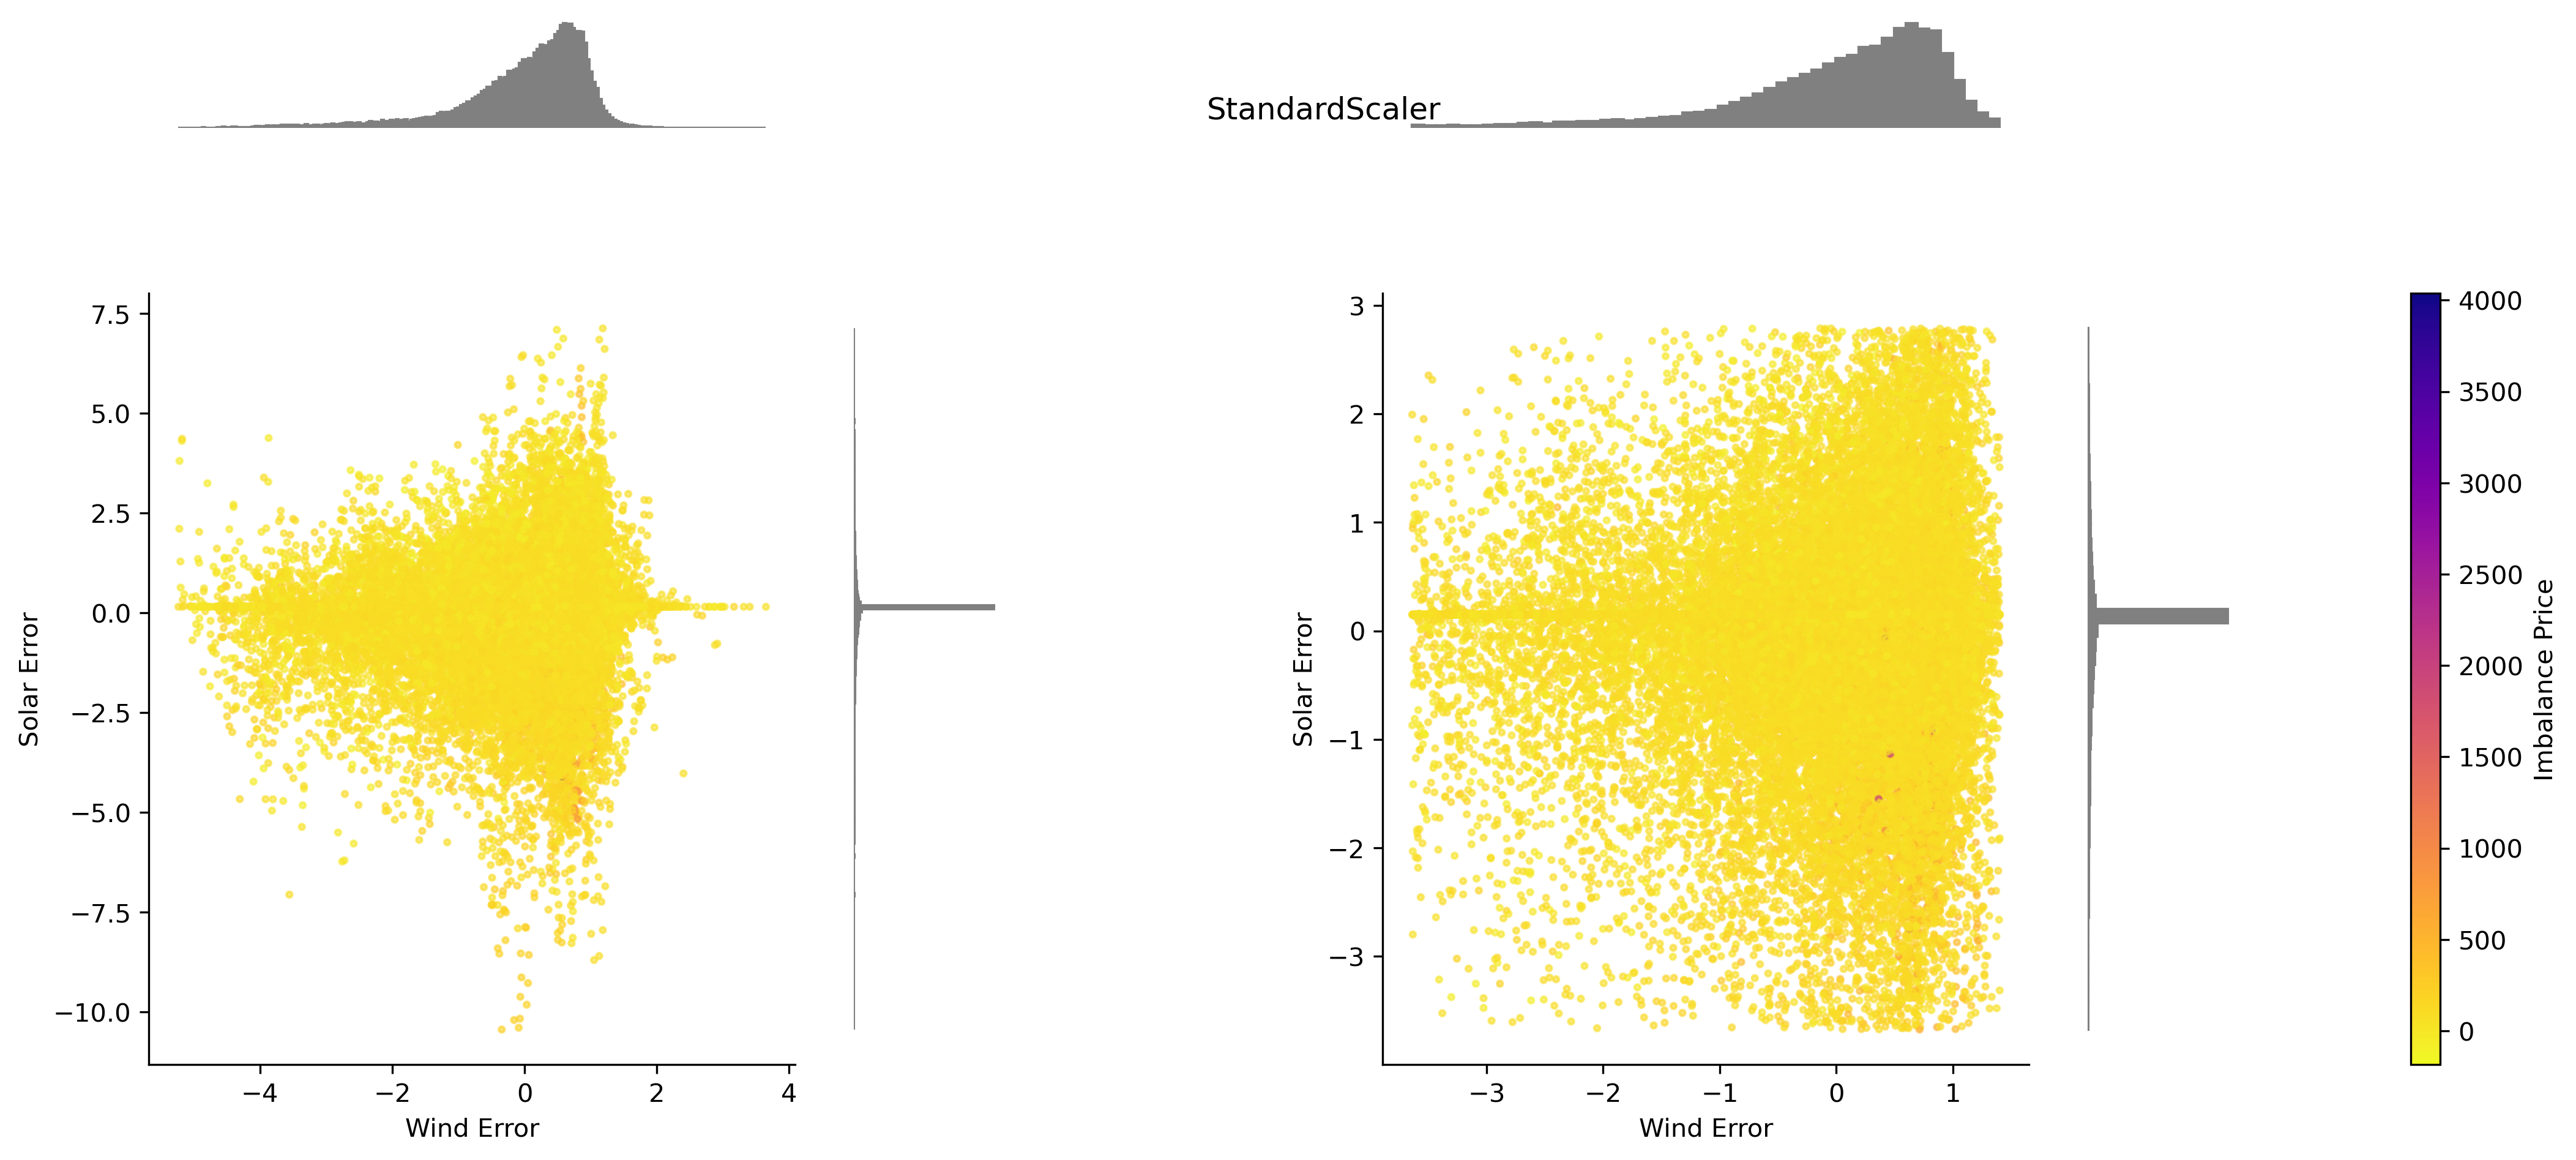

In [37]:
make_plot(1)

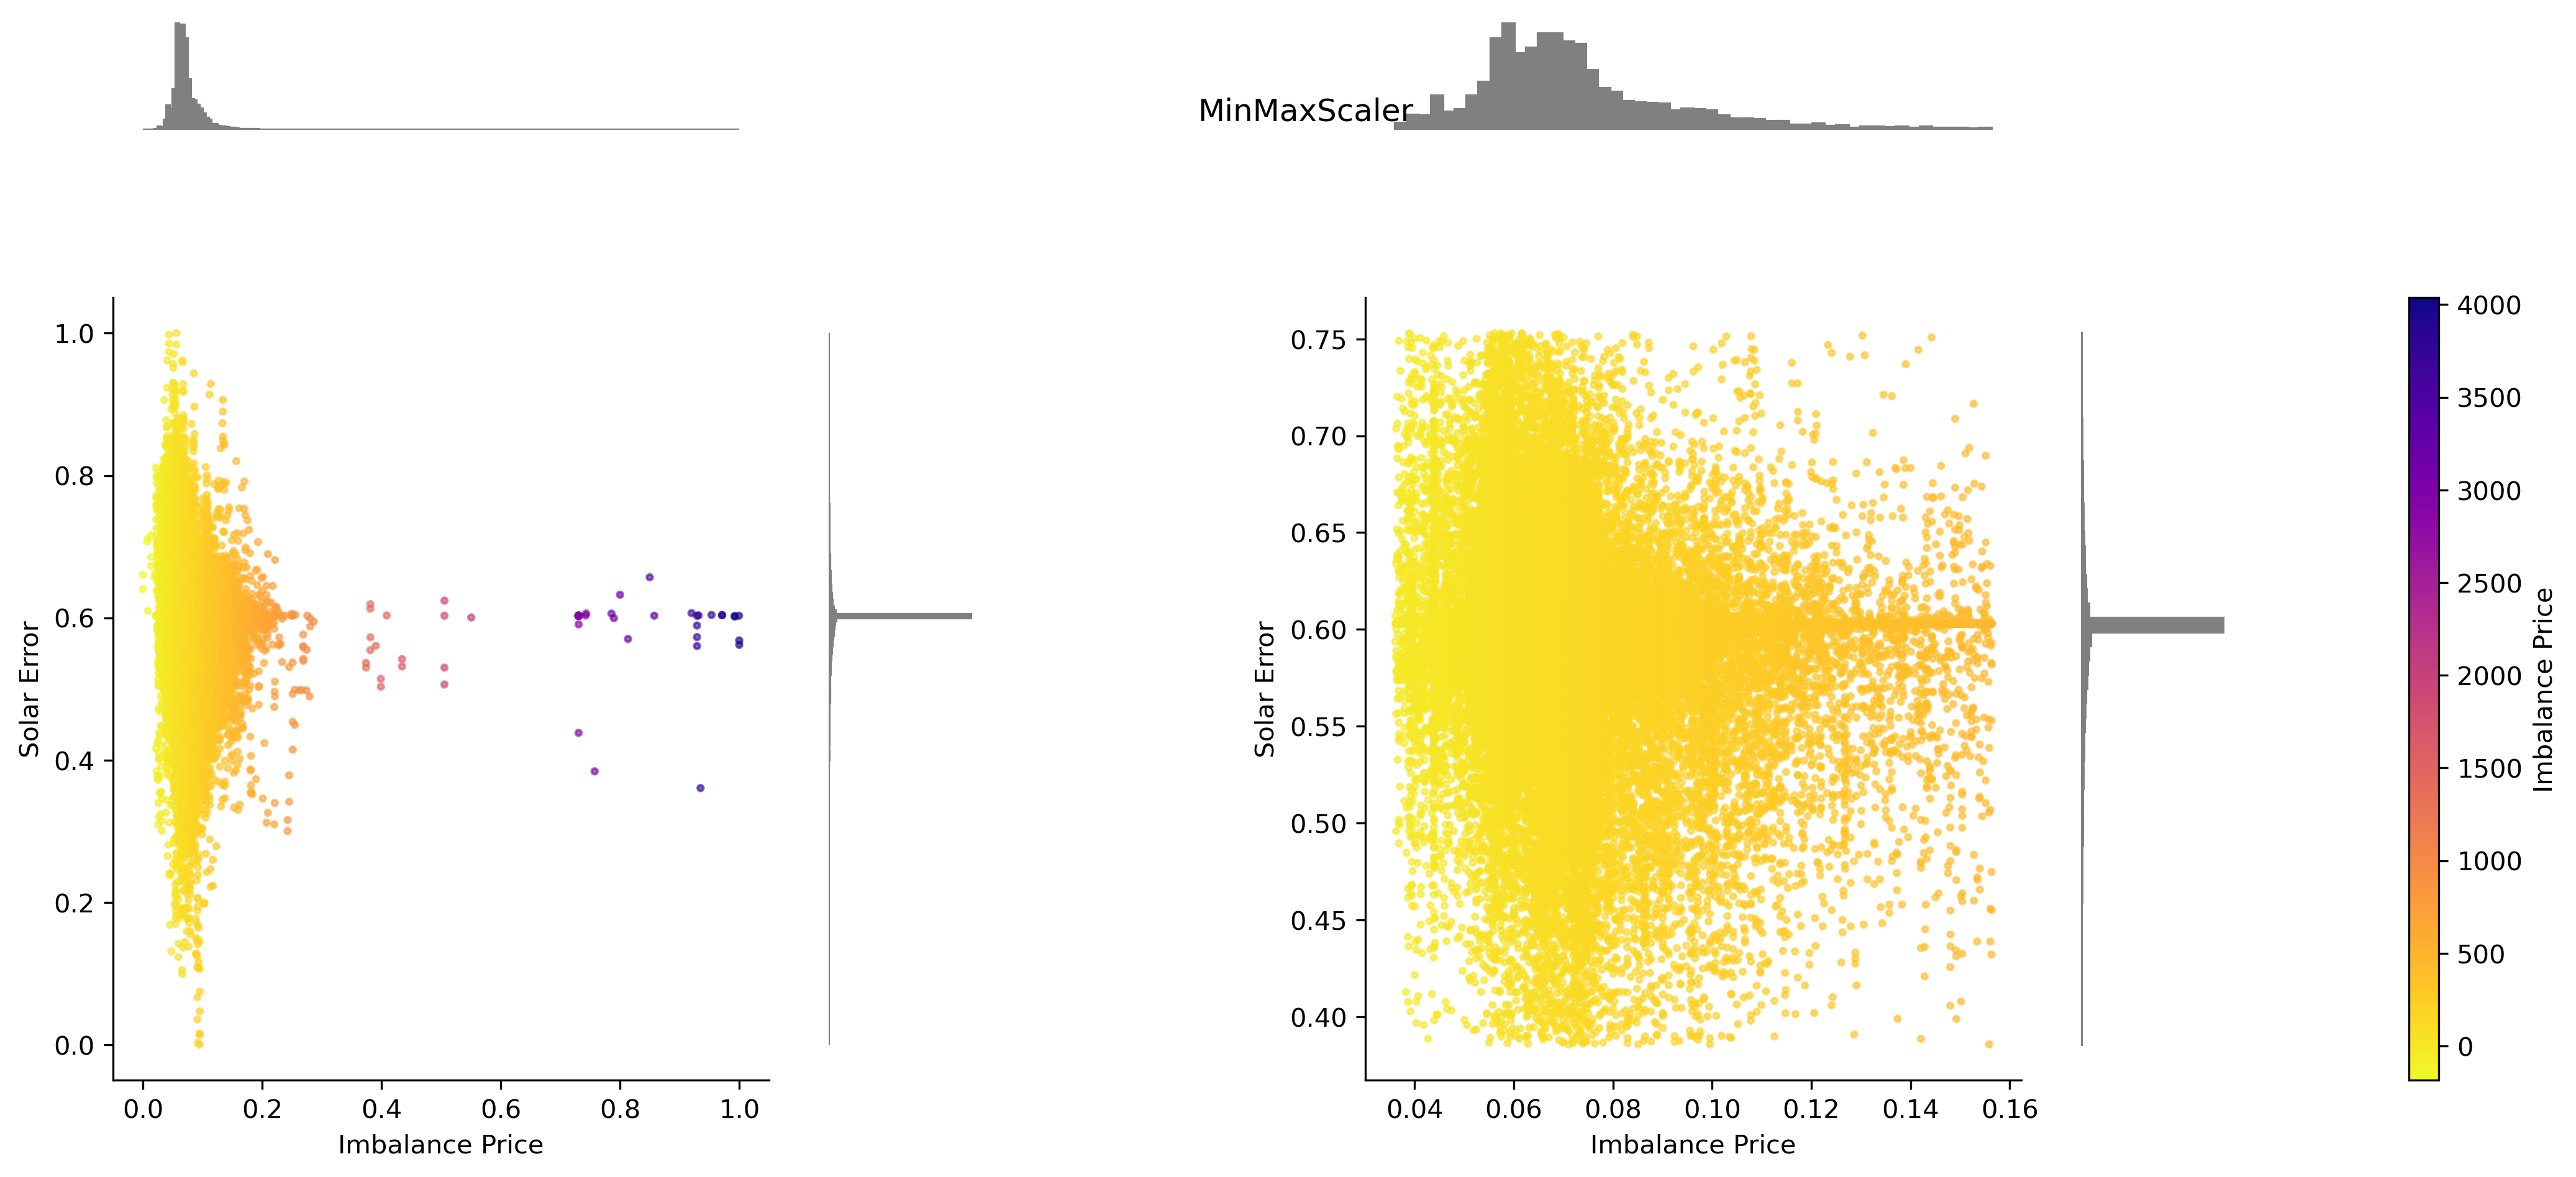

In [42]:
make_plot(2)

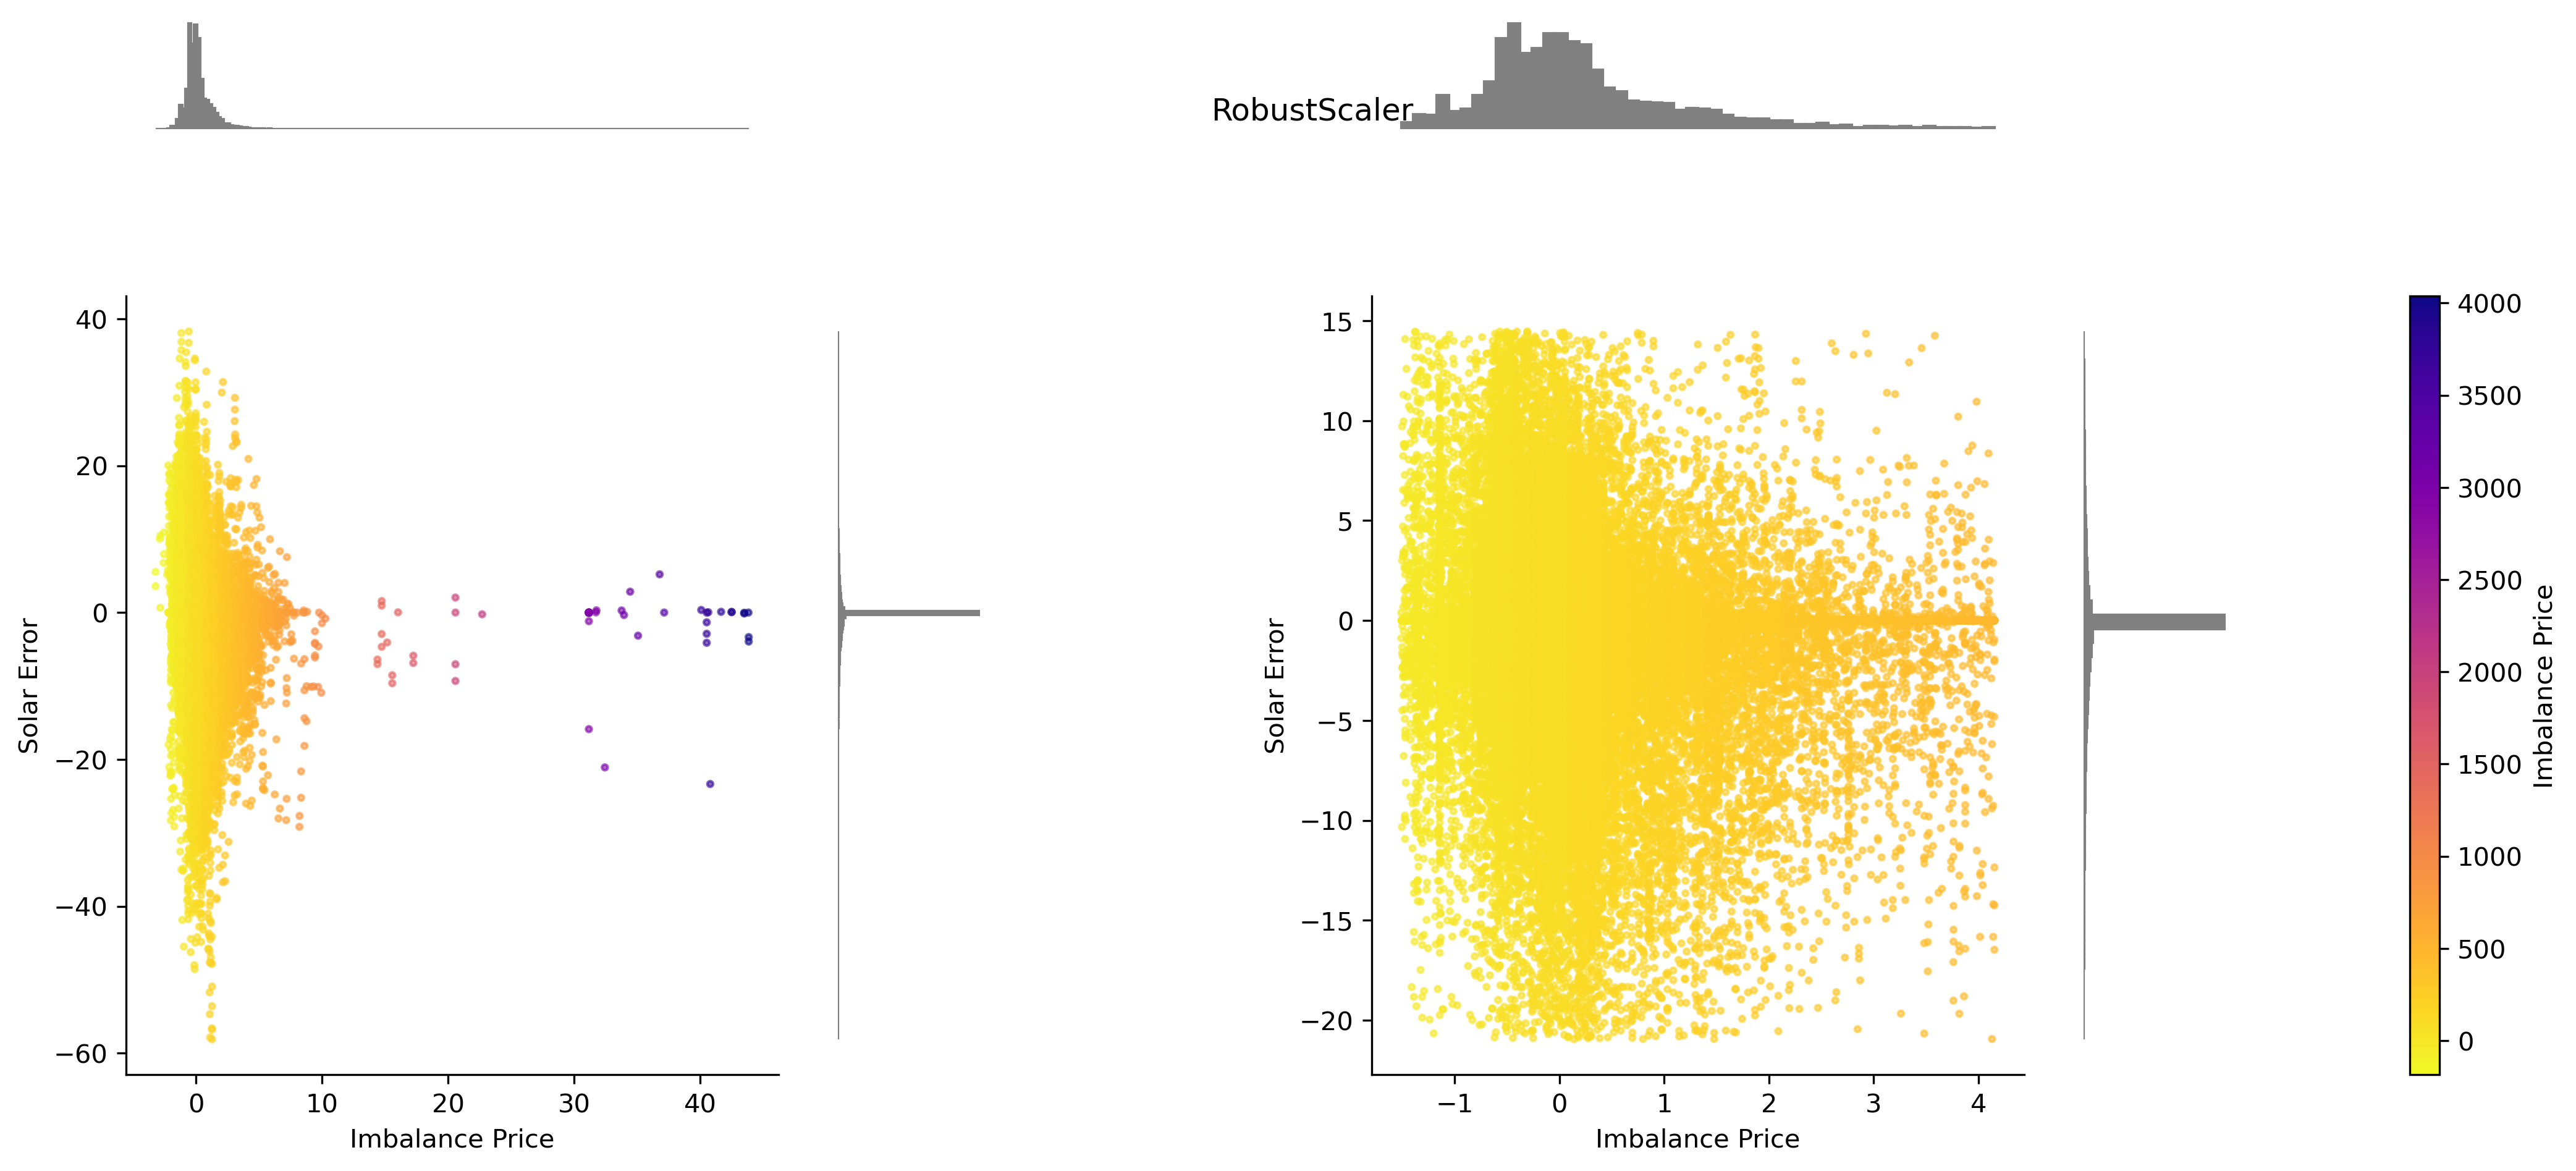

In [43]:
make_plot(4)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (6).

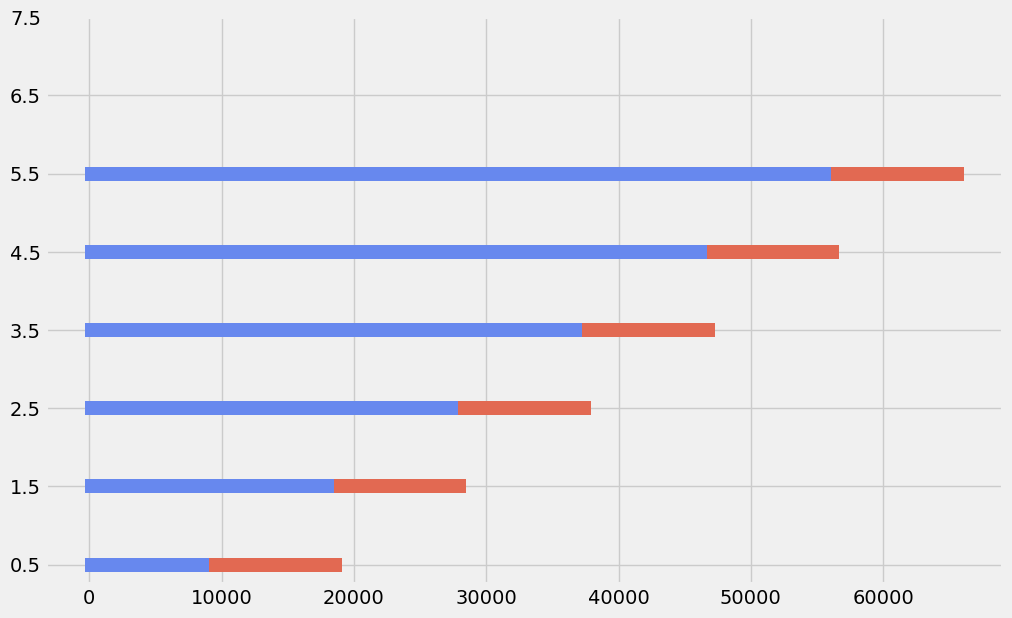

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 30
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

plot_cv_indices(TimeSeriesSplit(n_splits=6), n_splits=6, X=X_trainval, y=y_trainval, date_col=None)